<a href="https://colab.research.google.com/github/laylamoguibmm/Tasks/blob/main/task6_elevvopaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
print("Shape of X before CNN:", X.shape)


Shape of X before CNN: (999, 13, 130, 1)


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [33]:
 #--- CONFIG ---
AUDIO_ROOT = "/content/drive/MyDrive/archive (7)/Data/genres_original"
FEATURES_CSV = "/content/drive/MyDrive/archive (7)/Data/features_30_sec.csv"
SPECS_DIR_GEN = "/content/drive/MyDrive/archive (7)/Data/images_generated"   # will be created/used
SPECS_DIR_EXISTING = "/content/drive/MyDrive/archive (7)/Data/images_original" # if you already have spectrograms, else leave empty

MODEL_CNN_PATH = "/content/drive/MyDrive/genre_cnn_mfcc.h5"
MODEL_TL_PATH  = "/content/drive/MyDrive/genre_tl_mobilenet.h5"
TAB_RF_PATH    = "/content/drive/MyDrive/genre_tabular_rf.pkl"
TAB_MLP_PATH   = "/content/drive/MyDrive/genre_tabular_mlp.pkl"
SCALER_PATH    = "/content/drive/MyDrive/feature_scaler.pkl"
LABEL_ENC_PATH = "/content/drive/MyDrive/label_encoder.pkl"
RESULTS_CSV    = "/content/drive/MyDrive/genre_model_results.csv"


In [34]:
# --- SPEED/ROBUSTNESS KNOBS ---
USE_SUBSET_GENRES = False                 # set True to quickly test
SUBSET_GENRES = ['jazz', 'classical']     # only used if USE_SUBSET_GENRES=True
AUDIO_DURATION_SEC = 15                   # 30 for full; 10–15 for faster runs
N_MFCC = 13
MAX_PAD_LEN = 130                         # MFCC time steps target
IMG_SIZE = (128, 128)                     # for MobileNetV2
BATCH_SIZE = 32
EPOCHS_CNN = 12                           # 25–30 for better accuracy
EPOCHS_TL  = 6                            # 10+ for better accuracy

In [35]:
# ============================================================
# 0) Imports & setup
# ============================================================
import os, glob, pickle, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa, librosa.display

from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

# Ensure deterministic-ish
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
# ============================================================
# 1) Tabular approach on features_30_sec.csv
# ============================================================
print("=== TABULAR: loading feature CSV ===")
df = pd.read_csv(FEATURES_CSV)

# clean columns
drop_cols = [c for c in ['filename','length'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

# separate X,y
assert 'label' in df.columns, "CSV must have 'label' column."
X_tab = df.drop(columns=['label'])
y_tab = df['label']

# label encode, scale
le = LabelEncoder()
y_tab_enc = le.fit_transform(y_tab)
with open(LABEL_ENC_PATH, 'wb') as f: pickle.dump(le, f)

scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab.values)
with open(SCALER_PATH, 'wb') as f: pickle.dump(scaler, f)

Xtr, Xte, ytr, yte = train_test_split(X_tab_scaled, y_tab_enc, test_size=0.2, random_state=42, stratify=y_tab_enc)

# RandomForest
rf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)
rf_pred = rf.predict(Xte)
rf_acc = accuracy_score(yte, rf_pred)
print(f"✅ Tabular RF Acc: {rf_acc*100:.2f}%")
print(classification_report(yte, rf_pred, target_names=le.classes_))
cm_rf = confusion_matrix(yte, rf_pred)

# MLP (simple)
mlp = MLPClassifier(hidden_layer_sizes=(256,128), activation='relu', learning_rate_init=1e-3,
                    alpha=1e-4, batch_size=64, max_iter=50, random_state=42)
mlp.fit(Xtr, ytr)
mlp_pred = mlp.predict(Xte)
mlp_acc = accuracy_score(yte, mlp_pred)
print(f"✅ Tabular MLP Acc: {mlp_acc*100:.2f}%")
print(classification_report(yte, mlp_pred, target_names=le.classes_))
cm_mlp = confusion_matrix(yte, mlp_pred)

# save tabular models
with open(TAB_RF_PATH, 'wb') as f: pickle.dump(rf, f)
with open(TAB_MLP_PATH, 'wb') as f: pickle.dump(mlp, f)

=== TABULAR: loading feature CSV ===
✅ Tabular RF Acc: 71.00%
              precision    recall  f1-score   support

       blues       0.82      0.70      0.76        20
   classical       0.79      0.95      0.86        20
     country       0.86      0.90      0.88        20
       disco       0.50      0.35      0.41        20
      hiphop       0.61      0.70      0.65        20
        jazz       0.76      0.80      0.78        20
       metal       0.76      0.80      0.78        20
         pop       0.82      0.90      0.86        20
      reggae       0.48      0.50      0.49        20
        rock       0.62      0.50      0.56        20

    accuracy                           0.71       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.70      0.71      0.70       200

✅ Tabular MLP Acc: 76.00%
              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.89      0.85      0.87 

In [37]:
# ============================================================
# 2) Helper: robust MFCC extraction (for CNN)
# ============================================================
SAMPLE_RATE = 22050
DURATION = AUDIO_DURATION_SEC
def extract_mfcc_fixed(path, n_mfcc=N_MFCC, target_len=MAX_PAD_LEN):
    try:
        y, sr = librosa.load(path, sr=SAMPLE_RATE)  # load full, not duration-limited
        # take first DURATION seconds (pad if needed)
        need = int(DURATION * SAMPLE_RATE)
        if len(y) < need:
            y = np.pad(y, (0, need - len(y)))
        else:
            y = y[:need]
        mf = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # pad/truncate time axis
        if mf.shape[1] < target_len:
            mf = np.pad(mf, ((0,0),(0, target_len - mf.shape[1])))
        else:
            mf = mf[:, :target_len]
        return mf.astype(np.float32)
    except Exception:
        return None


In [38]:
# ============================================================
# 3) Build MFCC “image” dataset (fast + optional subset)
# ============================================================
print("\n=== MFCC CNN: building dataset ===")
genres_all = sorted([g for g in os.listdir(AUDIO_ROOT) if os.path.isdir(os.path.join(AUDIO_ROOT, g))])
if USE_SUBSET_GENRES:
    genres = [g for g in genres_all if g in SUBSET_GENRES]
else:
    genres = genres_all

mfcc_list, labels_mfcc = [], []
for g in genres:
    gdir = os.path.join(AUDIO_ROOT, g)
    wavs = [f for f in os.listdir(gdir) if f.endswith('.wav')]
    for f in tqdm(wavs, desc=f"MFCC {g}"):
        fp = os.path.join(gdir, f)
        mf = extract_mfcc_fixed(fp)
        if mf is None:  # skip bad files
            continue
        mfcc_list.append(mf)
        labels_mfcc.append(g)

X_mfcc = np.array(mfcc_list)[..., np.newaxis]   # (N, n_mfcc, time, 1)
y_mfcc = le.transform(labels_mfcc)              # use same encoder as tabular
Xtr_m, Xte_m, ytr_m, yte_m = train_test_split(X_mfcc, y_mfcc, test_size=0.2, random_state=42, stratify=y_mfcc)



=== MFCC CNN: building dataset ===


MFCC rock: 100%|██████████| 100/100 [00:04<00:00, 20.17it/s]


In [42]:
# ============================================================
# 4) CNN on MFCC “images” 
# ============================================================
input_shape = (N_MFCC, MAX_PAD_LEN, 1)  # (13, 130, 1)

cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2,2), padding='same'),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),

    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(le.classes_), activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN
hist_cnn = cnn.fit(Xtr_m, ytr_m,
                   validation_data=(Xte_m, yte_m),
                   epochs=EPOCHS_CNN,
                   batch_size=BATCH_SIZE,
                   verbose=1)

# Evaluate CNN
cnn_eval = cnn.evaluate(Xte_m, yte_m, verbose=0)
cnn_acc = cnn_eval[1]
print(f"✅ MFCC-CNN Accuracy: {cnn_acc*100:.2f}%")

# Predictions & report
yhat_cnn = np.argmax(cnn.predict(Xte_m, verbose=0), axis=1)
cm_cnn = confusion_matrix(yte_m, yhat_cnn)
print(classification_report(yte_m, yhat_cnn, target_names=le.classes_))

# Save model
cnn.save(MODEL_CNN_PATH)


Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.1277 - loss: 3.5614 - val_accuracy: 0.2700 - val_loss: 2.1223
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.2457 - loss: 2.0649 - val_accuracy: 0.3550 - val_loss: 1.8773
Epoch 3/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.2944 - loss: 1.9206 - val_accuracy: 0.3350 - val_loss: 1.8338
Epoch 4/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.3256 - loss: 1.8214 - val_accuracy: 0.3700 - val_loss: 1.7050
Epoch 5/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.3600 - loss: 1.7479 - val_accuracy: 0.4150 - val_loss: 1.6794
Epoch 6/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.3802 - loss: 1.6999 - val_accuracy: 0.3950 - val_loss: 1.6795
Epoch 7/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.3926 - loss: 1.6872 - val_accuracy: 0.4100 - val_loss: 1.5515
Epoch 8/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.4318 - loss: 1.5747 - val_accuracy: 0.

              precision    recall  f1-score   support

       blues       0.43      0.30      0.35        20
   classical       0.71      0.85      0.77        20
     country       0.32      0.35      0.33        20
       disco       0.25      0.15      0.19        20
      hiphop       0.75      0.15      0.25        20
        jazz       0.40      0.50      0.44        20
       metal       0.65      0.85      0.74        20
         pop       0.42      0.85      0.57        20
      reggae       0.48      0.65      0.55        20
        rock       0.17      0.05      0.08        20

    accuracy                           0.47       200
   macro avg       0.46      0.47      0.43       200
weighted avg       0.46      0.47      0.43       200



In [43]:
# ============================================================
# 5) Transfer learning on spectrogram images (MobileNetV2)
#    - generate spectrograms only if directory is empty
# ============================================================
def ensure_spectrograms(src_audio_dir, out_img_dir, use_genres):
    # if images already exist (and seem populated), skip generation
    populated = os.path.isdir(out_img_dir) and any(os.listdir(out_img_dir))
    if populated:
        print("➡️ Spectrogram directory already populated; skipping generation.")
        return
    print("🎨 Generating mel-spectrogram PNGs (this can take a while)…")
    os.makedirs(out_img_dir, exist_ok=True)
    for g in use_genres:
        gdir = os.path.join(src_audio_dir, g)
        outg = os.path.join(out_img_dir, g)
        os.makedirs(outg, exist_ok=True)
        wavs = [f for f in os.listdir(gdir) if f.endswith('.wav')]
        for i, f in enumerate(tqdm(wavs, desc=f"Specs {g}")):
            fp = os.path.join(gdir, f)
            try:
                y, sr = librosa.load(fp, sr=SAMPLE_RATE)
                need = int(DURATION * SAMPLE_RATE)
                if len(y) < need: y = np.pad(y, (0, need - len(y)))
                else: y = y[:need]
                S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                S_dB = librosa.power_to_db(S, ref=np.max)

                plt.figure(figsize=(IMG_SIZE[0]/100, IMG_SIZE[1]/100))
                librosa.display.specshow(S_dB, sr=sr)
                plt.axis('off')
                outp = os.path.join(outg, f"{i:04d}.png")
                plt.savefig(outp, bbox_inches='tight', pad_inches=0, dpi=100)
                plt.close()
            except Exception:
                continue

# decide which spectrogram folder to use
SPECS_DIR = SPECS_DIR_EXISTING if (os.path.isdir(SPECS_DIR_EXISTING) and any(os.listdir(SPECS_DIR_EXISTING))) else SPECS_DIR_GEN
ensure_spectrograms(AUDIO_ROOT, SPECS_DIR, genres)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(SPECS_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                        subset='training', shuffle=True)
val_gen   = datagen.flow_from_directory(SPECS_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                        subset='validation', shuffle=False)

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(len(train_gen.class_indices), activation='softmax')(x)
tl_model = Model(inputs=base.input, outputs=out)
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist_tl = tl_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_TL, verbose=1)
tl_eval = tl_model.evaluate(val_gen, verbose=0)
tl_acc = tl_eval[1]
print(f"✅ Transfer Learning Acc (val): {tl_acc*100:.2f}%")
tl_model.save(MODEL_TL_PATH)

➡️ Spectrogram directory already populated; skipping generation.
Found 808 images belonging to 10 classes.
Found 201 images belonging to 10 classes.
Epoch 1/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.1710 - loss: 2.6677 - val_accuracy: 0.3582 - val_loss: 1.7969
Epoch 2/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 869ms/step - accuracy: 0.3550 - loss: 1.7816 - val_accuracy: 0.4279 - val_loss: 1.5493
Epoch 3/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4990 - loss: 1.5316 - val_accuracy: 0.4577 - val_loss: 1.4622
Epoch 4/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 815ms/step - accuracy: 0.4724 - loss: 1.4660 - val_accuracy: 0.4428 - val_loss: 1.4702
Epoch 5/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 712ms/step - accuracy: 0.5134 - loss: 1.3537 - val_accuracy: 0.4925 - val_loss: 1.4583
Epoch 6/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 624ms/step - accuracy: 0.5860 - loss: 1.2250 - val_accuracy: 0.4826 - val_loss: 1.4083


✅ Transfer Learning Acc (val): 48.26%


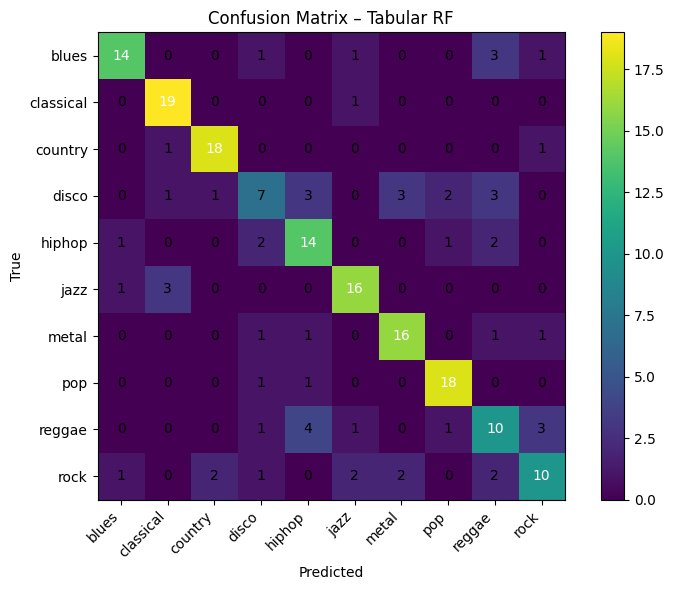

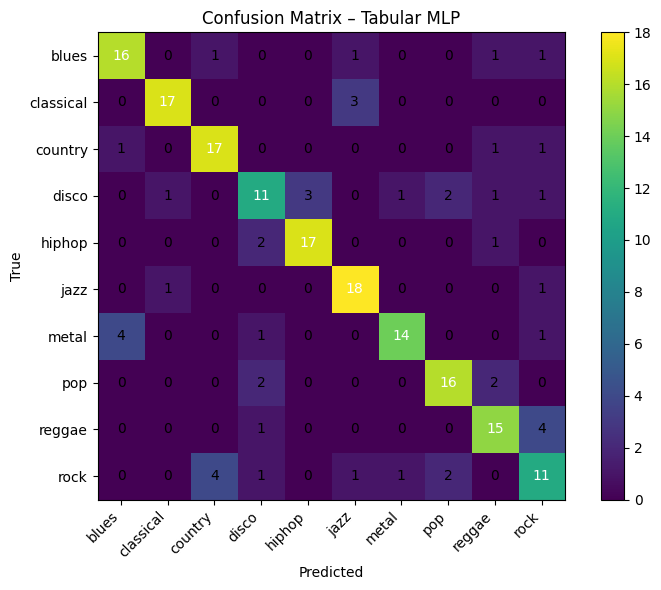

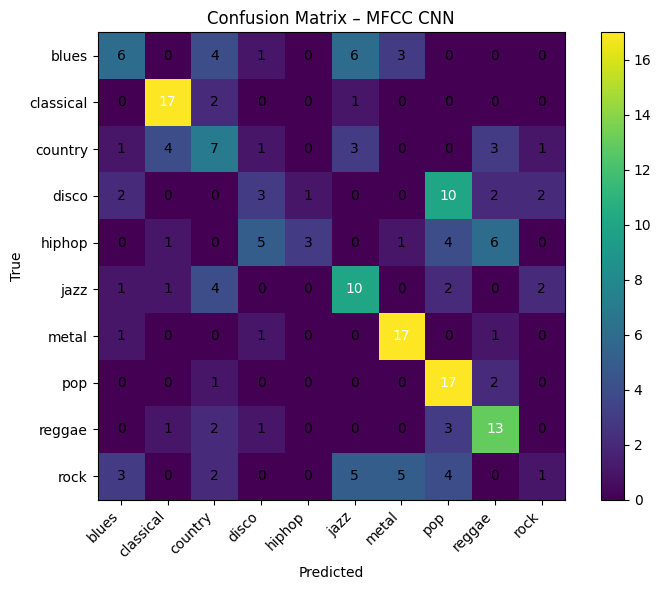

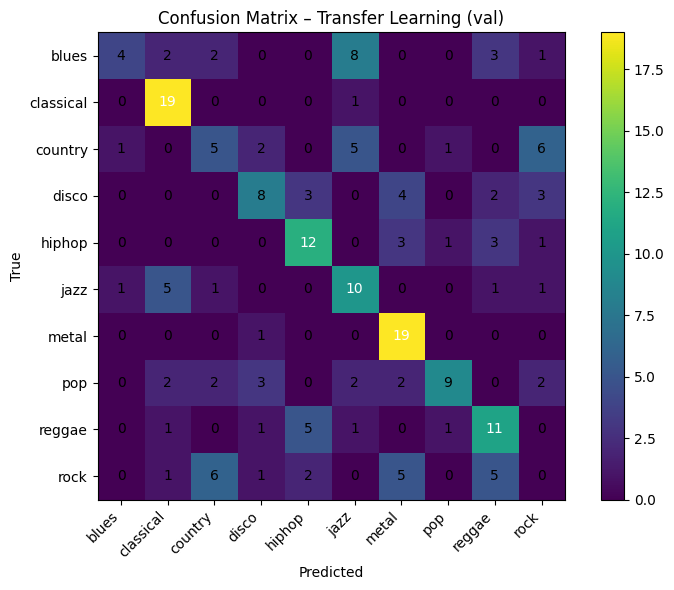


=== BONUS: Regression (predict tempo from features) ===
✅ Regression (tempo): MAE=22.59, R2=-0.082


In [44]:
# ============================================================
# 6) Confusion matrices (Tabular RF, MLP, MFCC-CNN, TL)
# ============================================================
def plot_cm(cm, labels, title):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right')
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

plot_cm(cm_rf,  le.classes_, "Confusion Matrix – Tabular RF")
plot_cm(cm_mlp, le.classes_, "Confusion Matrix – Tabular MLP")
plot_cm(cm_cnn, le.classes_, "Confusion Matrix – MFCC CNN")

# TL confusion matrix (needs predictions)
yhat_tl = np.argmax(tl_model.predict(val_gen, verbose=0), axis=1)
cm_tl = confusion_matrix(val_gen.classes, yhat_tl)
inv_map = {v:k for k,v in val_gen.class_indices.items()}
labels_tl = [inv_map[i] for i in range(len(inv_map))]
plot_cm(cm_tl, labels_tl, "Confusion Matrix – Transfer Learning (val)")

# ============================================================
# 7) Bonuses
#    A) Regression: predict tempo from tabular features
# ============================================================
print("\n=== BONUS: Regression (predict tempo from features) ===")
assert 'tempo' in df.columns or 'tempo' in pd.read_csv(FEATURES_CSV).columns, "CSV needs a 'tempo' column for regression bonus."
df_reg = pd.read_csv(FEATURES_CSV)
df_reg = df_reg.drop(columns=drop_cols, errors='ignore')
y_reg = df_reg['tempo'].values
X_reg = df_reg.drop(columns=['label','tempo'])

scaler_r = StandardScaler()
Xr_scaled = scaler_r.fit_transform(X_reg.values)
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr_scaled, y_reg, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rfr.fit(Xr_tr, yr_tr)
yr_pred = rfr.predict(Xr_te)
mae = mean_absolute_error(yr_te, yr_pred)
r2  = r2_score(yr_te, yr_pred)
print(f"✅ Regression (tempo): MAE={mae:.2f}, R2={r2:.3f}")

In [45]:
# ============================================================
# 7) Bonuses
#    B) Tiny time-series forecasting demo (RMS next-step)
# ============================================================
print("\n=== BONUS: Time-series forecasting (RMS next-step) ===")
# pick a single audio file
any_genre = genres[0]
sample_wav = next(f for f in os.listdir(os.path.join(AUDIO_ROOT, any_genre)) if f.endswith('.wav'))
wav_path = os.path.join(AUDIO_ROOT, any_genre, sample_wav)

y, sr = librosa.load(wav_path, sr=SAMPLE_RATE)
need = int(20 * SAMPLE_RATE)  # 20 seconds window
y = y[:need] if len(y) >= need else np.pad(y, (0, need - len(y)))
rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512).flatten()  # ~time series

# build (X_t->y_{t+1}) samples
LAG = 20
Xs, Ys = [], []
for i in range(len(rms)-LAG-1):
    Xs.append(rms[i:i+LAG])
    Ys.append(rms[i+LAG])
Xs = np.array(Xs)[:, :, np.newaxis]
Ys = np.array(Ys)

# tiny LSTM
ts_in = Input(shape=(LAG,1))
h = layers.LSTM(32, return_sequences=False)(ts_in)
h = layers.Dense(16, activation='relu')(h)
ts_out = layers.Dense(1)(h)
ts_model = Model(ts_in, ts_out)
ts_model.compile(optimizer='adam', loss='mae')
ts_model.fit(Xs, Ys, epochs=5, batch_size=64, verbose=0)
ts_mae = ts_model.evaluate(Xs, Ys, verbose=0)
print(f"✅ Forecasting demo – RMS next step MAE: {ts_mae:.4f}")


=== BONUS: Time-series forecasting (RMS next-step) ===
✅ Forecasting demo – RMS next step MAE: 0.0353


In [46]:
# ============================================================
# 8) Results table + save
# ============================================================
results = pd.DataFrame({
    "Model": ["Tabular RF", "Tabular MLP", "MFCC CNN", "TL MobileNetV2"],
    "Accuracy": [rf_acc, mlp_acc, cnn_acc, tl_acc]
}).sort_values("Accuracy", ascending=False)
print("\n=== ACCURACY COMPARISON ===")
print(results.to_string(index=False))
results.to_csv(RESULTS_CSV, index=False)
print(f"\n📄 Saved results to: {RESULTS_CSV}")


=== ACCURACY COMPARISON ===
         Model  Accuracy
   Tabular MLP  0.760000
    Tabular RF  0.710000
TL MobileNetV2  0.482587
      MFCC CNN  0.470000

📄 Saved results to: /content/drive/MyDrive/genre_model_results.csv


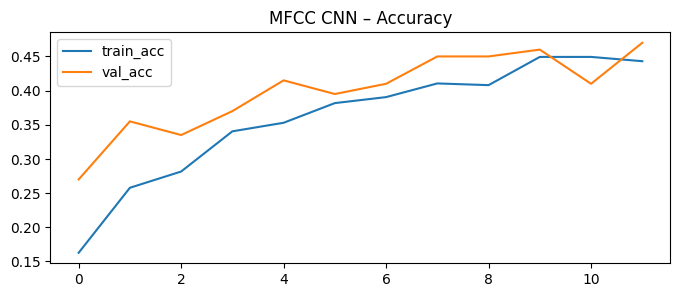

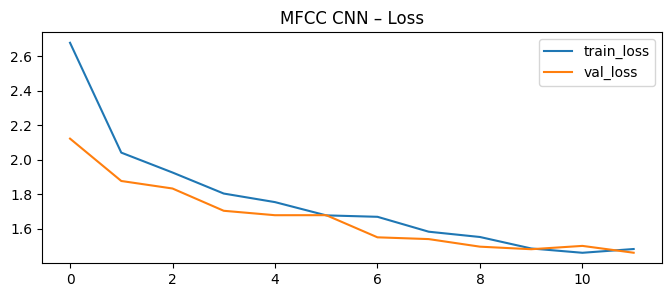

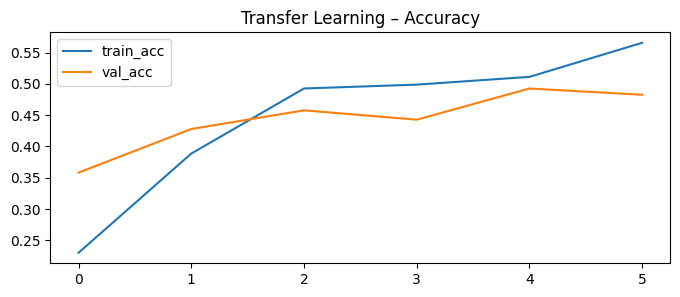

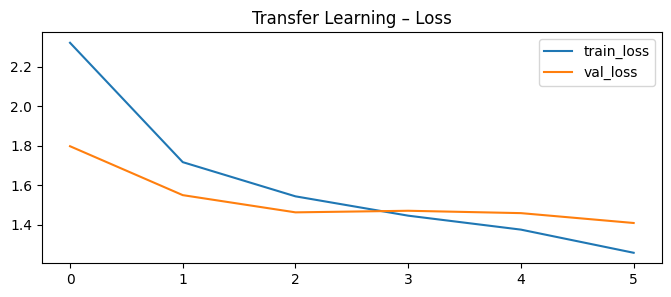

In [47]:
# ============================================================
# 9) Quick training curves (optional)
# ============================================================
def plot_train_curves(history, title):
    plt.figure(figsize=(8,3))
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='train_acc')
        if 'val_accuracy' in history.history: plt.plot(history.history['val_accuracy'], label='val_acc')
        plt.legend(); plt.title(f'{title} – Accuracy'); plt.show()
    if 'loss' in history.history:
        plt.figure(figsize=(8,3))
        plt.plot(history.history['loss'], label='train_loss')
        if 'val_loss' in history.history: plt.plot(history.history['val_loss'], label='val_loss')
        plt.legend(); plt.title(f'{title} – Loss'); plt.show()

plot_train_curves(hist_cnn, "MFCC CNN")
plot_train_curves(hist_tl,  "Transfer Learning")